In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils.multiclass import type_of_target
from sklearn.model_selection import train_test_split
plt.rcParams["font.sans-serif"]=["SimHei"] #设置字体
plt.rcParams["axes.unicode_minus"]=False #该语句解决图像中的“-”负号的乱码问题
decision_node = dict(boxstyle='round,pad=0.3', fc='#FAEBD7')
leaf_node = dict(boxstyle='round,pad=0.3', fc='#F4A460')
arrow_args = dict(arrowstyle="<-")

节点类

In [2]:
class Node(object):
    def __init__(self):
        self.feature_name = None        # 名称
        self.feature_index = None
        self.subtree = {}               # 子树
        self.impurity = None             
        self.is_continuous = False      # 类型：连续/离散
        self.split_value = None         # 分割值
        self.is_leaf = False            # 是否叶结点
        self.leaf_class = None          # 叶结点类别
        self.leaf_num = None
        self.high = -1

剪枝相关函数

In [3]:
def post_pruning(X_train, y_train, X_val, y_val, tree_=None):
    '''
    后剪枝函数
    返回：当前结点
    '''
    if tree_.is_leaf:
        return tree_

    if X_val.empty:         # 验证集为空集时，不再剪枝
        return tree_

    most_common_in_train = pd.value_counts(y_train).index[0]
    current_accuracy = np.mean(y_val == most_common_in_train)  # 当前节点下验证集样本准确率

    if tree_.is_continuous:
        up_part_train = X_train.loc[:, tree_.feature_name] >= tree_.split_value
        down_part_train = X_train.loc[:, tree_.feature_name] < tree_.split_value
        up_part_val = X_val.loc[:, tree_.feature_name] >= tree_.split_value
        down_part_val = X_val.loc[:, tree_.feature_name] < tree_.split_value

        up_subtree = post_pruning(X_train[up_part_train], y_train[up_part_train], X_val[up_part_val],
                                  y_val[up_part_val],
                                  tree_.subtree['>= {:.3f}'.format(tree_.split_value)])
        tree_.subtree['>= {:.3f}'.format(tree_.split_value)] = up_subtree
        down_subtree = post_pruning(X_train[down_part_train], y_train[down_part_train],
                                    X_val[down_part_val], y_val[down_part_val],
                                    tree_.subtree['< {:.3f}'.format(tree_.split_value)])
        tree_.subtree['< {:.3f}'.format(tree_.split_value)] = down_subtree

        tree_.high = max(up_subtree.high, down_subtree.high) + 1
        tree_.leaf_num = (up_subtree.leaf_num + down_subtree.leaf_num)

        if up_subtree.is_leaf and down_subtree.is_leaf:
            def split_fun(x):
                if x >= tree_.split_value:
                    return '>= {:.3f}'.format(tree_.split_value)
                else:
                    return '< {:.3f}'.format(tree_.split_value)

            val_split = X_val.loc[:, tree_.feature_name].map(split_fun)
            right_class_in_val = y_val.groupby(val_split).apply(
                lambda x: np.sum(x == tree_.subtree[x.name].leaf_class))
            split_accuracy = right_class_in_val.sum() / y_val.shape[0]

            if current_accuracy > split_accuracy:  # 若当前节点为叶节点时的准确率大于不剪枝的准确率，则进行剪枝操作——将当前节点设为叶节点
                set_leaf(pd.value_counts(y_train).index[0], tree_)
    else:
        max_high = -1
        tree_.leaf_num = 0
        is_all_leaf = True  # 判断当前节点下，所有子树是否都为叶节点

        for key in tree_.subtree.keys():
            this_part_train = X_train.loc[:, tree_.feature_name] == key
            this_part_val = X_val.loc[:, tree_.feature_name] == key

            tree_.subtree[key] = post_pruning(X_train[this_part_train], y_train[this_part_train],
                                              X_val[this_part_val], y_val[this_part_val], tree_.subtree[key])
            if tree_.subtree[key].high > max_high:
                max_high = tree_.subtree[key].high
            tree_.leaf_num += tree_.subtree[key].leaf_num

            if not tree_.subtree[key].is_leaf:
                is_all_leaf = False
        tree_.high = max_high + 1

        if is_all_leaf:  # 若所有子节点都为叶节点，则考虑是否进行剪枝
            right_class_in_val = y_val.groupby(X_val.loc[:, tree_.feature_name]).apply(
                lambda x: np.sum(x == tree_.subtree[x.name].leaf_class))
            split_accuracy = right_class_in_val.sum() / y_val.shape[0]

            if current_accuracy > split_accuracy:  # 若当前节点为叶节点时的准确率大于不剪枝的准确率，则进行剪枝操作——将当前节点设为叶节点
                set_leaf(pd.value_counts(y_train).index[0], tree_)

    return tree_


In [4]:

def pre_pruning(X_train, y_train, X_val, y_val, tree_=None):
    if tree_.is_leaf:  # 若当前节点已经为叶节点，那么就直接return了
        return tree_

    if X_val.empty: # 验证集为空集时，不再剪枝
        return tree_

    most_common_in_train = pd.value_counts(y_train).index[0]
    current_accuracy = np.mean(y_val == most_common_in_train) #当前结点为叶结点时的准确率

    if tree_.is_continuous:  # 连续值时，需要将样本分割为两部分，来计算分割后的正确率

        split_accuracy = val_accuracy_after_split(X_train[tree_.feature_name], y_train,
                                                  X_val[tree_.feature_name], y_val,
                                                  split_value=tree_.split_value)

        if current_accuracy >= split_accuracy:  # 当前节点为叶节点时准确率大于或分割后的准确率时，选择不划分
            set_leaf(pd.value_counts(y_train).index[0], tree_)

        else:
            up_part_train = X_train.loc[:, tree_.feature_name] >= tree_.split_value
            down_part_train = X_train.loc[:, tree_.feature_name] < tree_.split_value
            up_part_val = X_val.loc[:, tree_.feature_name] >= tree_.split_value
            down_part_val = X_val.loc[:, tree_.feature_name] < tree_.split_value

            up_subtree = pre_pruning(X_train[up_part_train], y_train[up_part_train], X_val[up_part_val],
                                     y_val[up_part_val],
                                     tree_.subtree['>= {:.3f}'.format(tree_.split_value)])
            tree_.subtree['>= {:.3f}'.format(tree_.split_value)] = up_subtree
            down_subtree = pre_pruning(X_train[down_part_train], y_train[down_part_train],
                                       X_val[down_part_val],
                                       y_val[down_part_val],
                                       tree_.subtree['< {:.3f}'.format(tree_.split_value)])
            tree_.subtree['< {:.3f}'.format(tree_.split_value)] = down_subtree

            tree_.high = max(up_subtree.high, down_subtree.high) + 1
            tree_.leaf_num = (up_subtree.leaf_num + down_subtree.leaf_num)

    else:  # 若是离散值，则变量所有值，计算分割后正确率

        split_accuracy = val_accuracy_after_split(X_train[tree_.feature_name], y_train,
                                                  X_val[tree_.feature_name], y_val)

        if current_accuracy >= split_accuracy:
            set_leaf(pd.value_counts(y_train).index[0], tree_)

        else:
            max_high = -1
            tree_.leaf_num = 0
            for key in tree_.subtree.keys():
                this_part_train = X_train.loc[:, tree_.feature_name] == key
                this_part_val = X_val.loc[:, tree_.feature_name] == key
                tree_.subtree[key] = pre_pruning(X_train[this_part_train], y_train[this_part_train],
                                                 X_val[this_part_val],
                                                 y_val[this_part_val], tree_.subtree[key])
                if tree_.subtree[key].high > max_high:
                    max_high = tree_.subtree[key].high
                tree_.leaf_num += tree_.subtree[key].leaf_num
            tree_.high = max_high + 1
    return tree_


In [5]:

def set_leaf(leaf_class, tree_):
    # 设置节点为叶节点
    tree_.is_leaf = True  # 若划分前正确率大于划分后正确率。则选择不划分，将当前节点设置为叶节点
    tree_.leaf_class = leaf_class
    tree_.feature_name = None
    tree_.feature_index = None
    tree_.subtree = {}
    tree_.impurity = None
    tree_.split_value = None
    tree_.high = 0  # 重新设立高 和叶节点数量
    tree_.leaf_num = 1



In [6]:

def val_accuracy_after_split(feature_train, y_train, feature_val, y_val, split_value=None):
    # 若是连续值时，需要需要按切分点对feature 进行分组，若是离散值，则不用处理
    if split_value is not None:
        def split_fun(x):
            if x >= split_value:
                return '>= {:.3f}'.format(split_value)
            else:
                return '< {:.3f}'.format(split_value)

        train_split = feature_train.map(split_fun)
        val_split = feature_val.map(split_fun)

    else:
        train_split = feature_train
        val_split = feature_val

    majority_class_in_train = y_train.groupby(train_split).apply(
        lambda x: pd.value_counts(x).index[0])  # 计算各特征下样本最多的类别
    right_class_in_val = y_val.groupby(val_split).apply(
        lambda x: np.sum(x == majority_class_in_train[x.name]))  # 计算各类别对应的数量

    return right_class_in_val.sum() / y_val.shape[0]  # 返回准确率


决策树类

In [7]:
class decisionTree():

    def __init__(self,criterion='gini',pruning=None):
        '''
        初始化决策树
        参数：划分准则和剪枝方式
        '''
        self.criterion=criterion
        self.pruning=pruning

    def fit(self, X_train, y_train, X_val=None, y_val=None):
        '''
        生成决策树
        -------
        参数：
            X_train:训练集特征
            y_train:训练集标签
            X_val：验证集特征
            y_val：验证集标签
        返回：决策树
        '''

        if self.pruning is not None and (X_val is None or y_val is None):
            raise Exception('you must input X_val and y_val if you are going to pruning')

        X_train.reset_index(inplace=True, drop=True)
        y_train.reset_index(inplace=True, drop=True)

        if X_val is not None:
            X_val.reset_index(inplace=True, drop=True)
            y_val.reset_index(inplace=True, drop=True)

        self.columns = list(X_train.columns)  # 包括原数据的列名
        self.tree = self.generate_tree(X_train, y_train) #生成决策树，返回根节点

        if self.pruning == 'pre_pruning':
            pre_pruning(X_train, y_train, X_val, y_val, self.tree)
        elif self.pruning == 'post_pruning':
            post_pruning(X_train, y_train, X_val, y_val, self.tree)

        return self

    def generate_tree(self,X,y):
        '''
        解释：递归生成决策树
        输入：
            X：样本特征值
            y: 样本标签
        返回：
            决策树根节点
        '''
        tree=Node()                                             
        tree.leaf_num=0                                                            
        if y.nunique()==1:                                      # 返回条件1：如果D中样本属于一类（或者取值相同），则划分结束              
            tree.is_leaf=True                                 
            tree.leaf_class=y.values[0]                         # 设置结点类别为该属性
            tree.high=0                                       
            tree.leaf_num+=1                                    
            return tree                                         
            
        if X.empty or y.empty:                                  # 返回条件2：如果当前样本集为空，则划分结束；返回条件3：如果属性集为空，则划分结束
            tree.is_leaf=True                              
            tree.leaf_class=pd.value_counts(y).index[0]         # 设置叶结点类别为属性y中最多的类
            tree.high=0
            tree.leaf_num+=1
            return tree                                         

        best_name,best_impurity=self.choose_best_feature(X,y)   # 选择最优化分属性
        #print('best_name：',best_name)
        #print('best_impurity:',best_impurity)
        tree.feature_name=best_name                            
        tree.impurity=best_impurity[0]
        tree.feature_index=self.columns.index(best_name)
        feature_values = X.loc[:, best_name]

        if len(best_impurity)==1:                               # 如果为离散值
            tree.is_continuous=False
            unique_vals=pd.unique(feature_values)
            sub_X = X.drop(best_name, axis=1)                   # 去掉使用过的特征best_name

            max_high=-1
            for value in unique_vals:                           # 遍历每一个离散取值
                tree.subtree[value] = self.generate_tree(sub_X[feature_values == value], y[feature_values == value]) # 递归生成子树
                if tree.subtree[value].high > max_high:         
                    max_high = tree.subtree[value].high
                tree.leaf_num += tree.subtree[value].leaf_num
            tree.high=max_high+1

        elif len(best_impurity)==2:                             # 如果为连续值
            tree.is_continuous=True
            tree.split_value=best_impurity[1]
            up = '>= {:.3f}'.format(tree.split_value)           # 设置上界
            down = '< {:.3f}'.format(tree.split_value)          # 设置下界
            tree.subtree[up]=self.generate_tree(X[feature_values>=tree.split_value],y[feature_values>=tree.split_value])
            tree.subtree[down]=self.generate_tree(X[feature_values<tree.split_value],y[feature_values<tree.split_value])
            tree.leaf_num+=(tree.subtree[up].leaf_num+tree.subtree[down].leaf_num)
            tree.high=max(tree.subtree[up].high,tree.subtree[down].high)+1
        return tree



    def predict(self,X):      
        if X.ndim==1:
            return self.predict_single(X)
        else:
            return X.apply(self.predict_single,axis=1)
    
    def predict_single(self,x,subtree=None):    #单个预测
        if subtree is None:
            subtree=self.tree

        if subtree.is_leaf:
            return subtree.leaf_class

        if subtree.is_continuous:  # 若是连续值，需要判断是
            if x[subtree.feature_index] >= subtree.split_value:
                return self.predict_single(x, subtree.subtree['>= {:.3f}'.format(subtree.split_value)])
            else:
                return self.predict_single(x, subtree.subtree['< {:.3f}'.format(subtree.split_value)])
        else:
            return self.predict_single(x, subtree.subtree[x[subtree.feature_index]])        

    def choose_best_feature(self,X,y):
        if self.criterion == 'gini':
            return self.choose_best_feature_gini(X, y)
        elif self.criterion == 'infogain':
            return self.choose_best_feature_infogain(X, y)
        elif self.criterion == 'gainratio':
            return self.choose_best_feature_gainratio(X, y)

    def choose_best_feature_gini(self,X,y): # 基于基尼指数选择
        features = X.columns
        best_feature_name = None
        best_gini = [float('inf')]
        for feature_name in features:       # 遍历每个特征
            is_continuous = type_of_target(X[feature_name]) == 'continuous'
            gini_idex = self.gini_index(X[feature_name], y, is_continuous) # 计算基尼指数
            #print('gini',gini_idex)
            if gini_idex[0] < best_gini[0]: # 选取最优值 
                best_feature_name = feature_name
                best_gini = gini_idex
        return best_feature_name,best_gini
        
    def choose_best_feature_infogain(self,X,y):
        '''
        以返回值中best_info_gain 的长度来判断当前特征是否为连续值，若长度为 1 则为离散值，若长度为 2 ， 则为连续值
        :param X: 当前所有特征的数据 pd.DaraFrame格式
        :param y: 标签值
        :return:  以信息增益来选择的最佳划分属性，第一个返回值为属性名称，

        '''
        features = X.columns
        best_feature_name = None
        best_info_gain = [float('-inf')]
        entD = self.entroy(y)
        for feature_name in features:
            is_continuous = type_of_target(X[feature_name]) == 'continuous'
            info_gain = self.info_gain(X[feature_name], y, entD, is_continuous)
            if info_gain[0] > best_info_gain[0]:
                best_feature_name = feature_name
                best_info_gain = info_gain

        return best_feature_name, best_info_gain

    def choost_besy_feature_gainration(self,X,y):
        '''
        以返回值中best_gain_ratio 的长度来判断当前特征是否为连续值，若长度为 1 则为离散值，若长度为 2 ， 则为连续值
        :param X: 当前所有特征的数据 pd.DaraFrame格式
        :param y: 标签值
        :return:  以信息增益率来选择的最佳划分属性，第一个返回值为属性名称，第二个为最佳划分属性对应的信息增益率
        '''
        features = X.columns
        best_feature_name = None
        best_gain_ratio = [float('-inf')]
        entD = self.entroy(y)

        for feature_name in features:
            is_continuous = type_of_target(X[feature_name]) == 'continuous'
            info_gain_ratio = self.info_gainRatio(X[feature_name], y, entD, is_continuous)
            if info_gain_ratio[0] > best_gain_ratio[0]:
                best_feature_name = feature_name
                best_gain_ratio = info_gain_ratio

        return best_feature_name, best_gain_ratio

    def gini_index(self,feature,y,is_continuous=False):
        '''
        解释：计算基尼指数
        输入：
            feature:特征为feature的样本
            y:样本标签
        返回：
            基尼指数
        '''
        m=y.shape[0]
        unique_value = pd.unique(feature)
        if is_continuous: #特征值连续
            unique_value.sort()
            split_point_set=[(unique_value[i]+unique_value[i+1])/2 for i in range(len(unique_value)-1)] # 得到划分点集合
            min_gini = float('inf')
            min_gini_point = None
            for split_point_ in split_point_set:  # 遍历所有的分割点，寻找基尼指数最小的分割点
                Dv1 = y[feature <= split_point_]
                Dv2 = y[feature > split_point_]
                gini_index = Dv1.shape[0] / m * self.gini(Dv1) + Dv2.shape[0] / m * self.gini(Dv2)

                if gini_index < min_gini:        # 选取基尼指数最小的分割点
                    min_gini = gini_index
                    min_gini_point = split_point_
            return [min_gini, min_gini_point]
        else:   # 特征值离散
            gini_index=0
            for value in unique_value: # 遍历每一个特征取值
                Dv=y[feature==value]   #获取属性a上取值为v的样本 
                m_Dv = Dv.shape[0]     
                gini_index+=m_Dv/m*self.gini(Dv) # 求和基尼指数
        return [gini_index]
        
    def gini(self,y):
        p=pd.value_counts(y)/y.shape[0]
        gini=1-np.sum(p**2)
        return gini

    def info_gain(self, feature, y, entD, is_continuous=False):
        '''
        计算信息增益
        ------
        参数： 
            feature: 当前特征下所有样本值
            y:       对应标签值
        返回: 
            当前特征的信息增益, list类型，若当前特征为离散值则只有一个元素为信息增益，若为连续值，则第一个元素为信息增益，第二个元素为切分点
        '''
        m = y.shape[0]
        unique_value = pd.unique(feature)
        if is_continuous:
            unique_value.sort()  # 排序, 用于建立分割点
            split_point_set = [(unique_value[i] + unique_value[i + 1]) / 2 for i in range(len(unique_value) - 1)] # 得到划分点集
            min_ent = float('inf')  # 挑选信息熵最小的分割点
            min_ent_point = None
            for split_point_ in split_point_set:    #遍划分点集
                Dv1 = y[feature <= split_point_]   
                Dv2 = y[feature > split_point_]
                #计算划分后的信息熵
                feature_ent_ = Dv1.shape[0] / m * self.entroy(Dv1) + Dv2.shape[0] / m * self.entroy(Dv2)
                if feature_ent_ < min_ent:
                    min_ent = feature_ent_
                    min_ent_point = split_point_
            gain = entD - min_ent
            return [gain, min_ent_point]

    def info_gainRatio(self, feature, y, entD, is_continuous=False):
        '''
        计算信息增益率 参数和info_gain方法中参数一致
        ------
        :param feature:
        :param y:
        :param entD:
        :return:
        '''

        if is_continuous:

            gain, split_point = self.info_gain(feature, y, entD, is_continuous)
            p1 = np.sum(feature <= split_point) / feature.shape[0]  # 小于或划分点的样本占比
            p2 = 1 - p1  # 大于划分点样本占比
            IV = -(p1 * np.log2(p1) + p2 * np.log2(p2)) # 《机器学习》4.4式

            grain_ratio = (gain - np.log2(feature.nunique()) / len(y)) / IV  # 对信息增益修正
            return [grain_ratio, split_point]
        else:
            p = pd.value_counts(feature) / feature.shape[0]  # 当前特征下 各取值样本所占比率
            IV = np.sum(-p * np.log2(p))  # 《机器学习》4.4式
            grain_ratio = self.info_gain(feature, y, entD, is_continuous)[0] / IV
            return [grain_ratio]

    def entroy(self, y):
        p = pd.value_counts(y) / y.shape[0]  # 计算各类样本所占比率
        ent = np.sum(-p * np.log2(p))
        return ent


In [8]:

def plot_node(node_text, center_pt, parent_pt, node_type, ax_):
    ax_.annotate(node_text, xy=[parent_pt[0], parent_pt[1] - 0.02], xycoords='axes fraction',
                 xytext=center_pt, textcoords='axes fraction',
                 va="center", ha="center", size=15,
                 bbox=node_type, arrowprops=arrow_args)

def plot_mid_text(mid_text, center_pt, parent_pt, ax_):
    x_mid = (parent_pt[0] - center_pt[0]) / 2 + center_pt[0]
    y_mid = (parent_pt[1] - center_pt[1]) / 2 + center_pt[1]
    ax_.text(x_mid, y_mid, mid_text, fontdict=dict(size=10))

def plot_tree(tree,parent,node_text,ax):
    global y_off
    global x_off
    global total_num_leaf
    global total_high

    num_of_leaf = tree.leaf_num
    center_pt = (x_off + (1 + num_of_leaf) / (2 * total_num_leaf), y_off)

    plot_mid_text(node_text, center_pt, parent, ax)

    if total_high == 0:  # total_high为零时，表示就直接为一个叶节点。因为西瓜数据集的原因，在预剪枝的时候，有时候会遇到这种情况。
        plot_node(tree.leaf_class, center_pt, parent, leaf_node, ax)
        return
    plot_node(tree.feature_name, center_pt, parent, decision_node, ax)

    y_off -= 1 / total_high
    for key in tree.subtree.keys():
        if tree.subtree[key].is_leaf:
            x_off += 1 / total_num_leaf
            plot_node(str(tree.subtree[key].leaf_class), (x_off, y_off), center_pt, leaf_node, ax)
            plot_mid_text(str(key), (x_off, y_off), center_pt, ax)
        else:
            plot_tree(tree.subtree[key], center_pt, str(key), ax)
    y_off += 1 / total_high


In [9]:
def creat_plot(tree):
    '''
    树的可视化函数
    参数：tree根节点
    '''
    global y_off
    global x_off
    global total_num_leaf
    global total_high
    total_num_leaf = tree.leaf_num
    total_high = tree.high
    y_off = 1
    x_off = -0.5 / total_num_leaf

    fig_, ax_ = plt.subplots()
    ax_.set_xticks([])  # 隐藏坐标轴刻度
    ax_.set_yticks([])
    ax_.spines['right'].set_color('none')  # 设置隐藏坐标轴
    ax_.spines['top'].set_color('none')
    ax_.spines['bottom'].set_color('none')
    ax_.spines['left'].set_color('none')
    plt.figure(figsize=(10, 10))
    plot_tree(tree, (0.5, 1), '', ax_)
    plt.show()

In [10]:
X=pd.read_csv("X.csv",index_col=0)
y=pd.read_csv("y.csv",index_col=0)
y=y["status"]
m,n=X.shape
X_train, X_test, y_train, y_test = train_test_split(X, y,train_size=0.8,random_state=1)

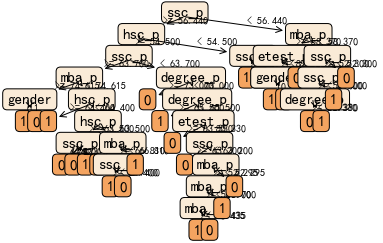

<Figure size 720x720 with 0 Axes>

In [11]:
CART_tree=decisionTree(criterion='gini')
CART_tree.fit(X_train,y_train)
creat_plot(CART_tree.tree)

In [12]:
X_test1=X_test[0:14]
y_test1=y_test[0:14]
y_pre=CART_tree.predict(X_test1)
s1=np.mean(y_pre == y_test1)
X_test2=X_test[22:42]
y_test2=y_test[22:42]
y_pre=CART_tree.predict(X_test2)


In [13]:

print('Accurancy：', (np.mean(y_pre == y_test2)+s1)/2)

Accurancy： 0.7535714285714286
